In [86]:
import CM_code.spurious_george as sp
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy
import importlib as imp
import DL_basis_code.shared_functions_setup as setup
import CM_code.tjp_helper as tjp_helper
import time

imp.reload(tjp_helper)
imp.reload(sp)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

print('Lens bin: %g - %g'%(sp.zed.zl_min, sp.zed.zl_max))
print('Source bin: %g - %g'%(sp.zed.zs_min, sp.zed.zs_max))

Lens bin: 0.2 - 1.2
Source bin: 0.05 - 3.5


### Load in theta, boost, and F data

In [42]:
F_theta = sp.get_F(theta_dependence=True, year=10)
B_min1, r_p = sp.get_boosts(year=10, out_file='boost_y10_tes_narrow_source')

Pk_gg calculated
xi_gg calculated
Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 0.2 - 0.4
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 4.32515 minutes


In [43]:
print(F_theta)
print(B_min1)

[0.00315687 0.00315687 0.00315687 0.00315687 0.00340064 0.00732642
 0.01578407]
[0.26373793 0.16011014 0.0852214  0.04092246 0.02250047 0.01406453
 0.00733806]


In [44]:
# load in redshift data
_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', year=10)
z_s, dndz_s, *_ = sp.zed.get_dndz_phot(gtype='source', year=10)
z_l, dndz_l, *_ = sp.zed.get_dndz_phot(gtype='lens', year=10)

theta = sp.rp_to_arcmin(r_p, zleff)

print(theta)

[ 0.41244312  0.88858177  1.91439139  4.12443122  8.8858177  19.1439139
 41.24431221]


Text(0, 0.5, 'B - 1')

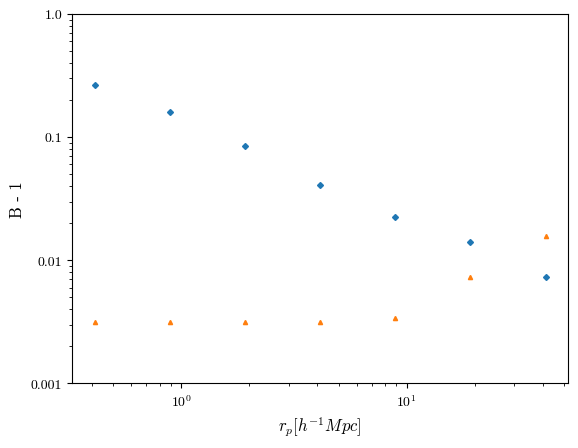

In [45]:
plt.plot(theta, B_min1, lw=0, marker='D', markersize=3.)
plt.plot(theta, F_theta, lw=0, marker='^', markersize=3.)
plt.xscale('log')
plt.yscale('log')
#plt.ylim([0.001, 6])
plt.yticks([0.001, 0.01, 0.1, 1.0],['0.001', '0.01', '0.1', '1.0'])
#plt.xticks([0.1, 1.0, 10.0], ['0.1','1.0','10'],fontsize=12)
plt.xlabel(r'$r_p [h^{-1} Mpc]$', fontsize=12)
plt.ylabel('B - 1', fontsize=12)

### Calculate maximum mbias lensing residual

In [75]:
# set ell values based on theta range
ell = np.unique(np.geomspace(180/(theta[-1]/60.) - 10, 180/(theta[0]/60.) + 10, 1024).astype(int))

# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E4, 3000)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.linspace(0.1,1,32), year=10)

lensTracer = ccl.NumberCountsTracer(sp.zed.cosmo_SRD, has_rsd=False, dndz=(z_l, dndz_l), 
                                bias=(z_l, sp.lens_bias(z_l, year=1)))
shearTracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), 
                                     has_shear=True
                                    )

# compute angular power spectrum for galaxy-galaxy lensing using H.O.D.s
Cl_gM = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, shearTracer, ell, p_of_k_a=pk_gMf)

# compute lensing shear
y_L = ccl.correlation(sp.halo.cosmo_SRD, ell, Cl_gM, theta / 60., type='NG')

In [76]:
# multiply by maximum residual bias and divide by P.A. fraction
# define multiplicative bias uncertainty
sigma_m = 0.013
delM_yL = 2.*sigma_m*y_L / (B_min1 + F_theta)
yL = y_L / (B_min1 + F_theta)

### Calculate theoretical IA signal using L-NLA model

In [47]:
# define IA model
f_red = 0.16
A_IA = 5.

IA_amps = f_red * A_IA * np.ones_like(z_s)

intrinsicTracer = ccl.WeakLensingTracer(sp.zed.cosmo_SRD, (z_s, dndz_s), has_shear=False, 
                                     ia_bias=(z_s, IA_amps))

# CALCULATE IA USING HALO MODEL POWER SPECTRUM

# defined to be same as in boost function
k_arr = np.geomspace(1E-4, 5E2, 3000)

a_l = 1. / (1. + z_l)

# create 2D power spectrum objects for galaxy-IA correlation
pk_gMf = sp.halo.get_Pk2D('gm', k_arr, np.flip(a_l))

# compute aps for galaxy-intrinsic
Cl_IA = ccl.angular_cl(sp.zed.cosmo_SRD, lensTracer, intrinsicTracer, ell, p_of_k_a=pk_gMf)

# get IA tangential shear
y_IA = ccl.correlation(sp.zed.cosmo_SRD, ell, Cl_IA, theta / 60., type='NG')
bar_yIA = y_IA / (B_min1 + F_theta)

### Load in Y1 covariance matrix and combine with lensing residual 

In [82]:
# create sacc file to pass data to TJP
tjp_helper.create_xi_t_sacc(year=10)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.3, 0.7, 0.9]
covs = tjp_helper.get_lsst_covariance(rho=rho, year=10)

#load in matrices and rho values
cov_file = np.load('generated_data/lsst-y10-covmats_rho=0.1-0.9.npz')
rho = cov_file['rho']
covs = cov_file['covs']

# add residual in quadrature to cov matrix
cov_IA = np.zeros_like(covs)
sigma_IA = np.zeros_like(covs[0])
for j in range(len(rho)):
    for i in range(len(theta)):
        for k in range(len(theta)):
            cov_IA[j,i,k] = (covs[j,i,k] / ((B_min1[i] + F_theta[i])*(B_min1[k] + F_theta[k]))) + delM_yL[i]*delM_yL[k]
    sigma_IA[j] = np.sqrt(np.diag(cov_IA[j,:,:]))

rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.41244312  0.88858177  1.91439139  4.12443122  8.8858177  19.1439139
 41.24431221]
Fraction of lenses in bin: 0.0908264
Fraction of source in bin: 0.280019
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(
Process ForkPoolWorker-6364:
Process ForkPoolWorker-6425:
Process ForkPoolWorker-6369:
Process ForkPoolWorker-6380:
Process ForkPoolWorker-6386:
Process ForkPoolWorker-6367:
Process ForkPoolWorker-6387:
Process ForkPoolWorker-6414:
Process ForkPoolWorker-6363:
Process ForkPoolWorker-6365:
Process ForkPoolWorker-6389:
Process ForkPoolWorker-6383:
Process ForkPoolWorker-6432:
Process ForkPoolWorker-6407:
Process ForkPoolWorker-6361:
Process ForkPoolWorker-6371:
Process ForkPoolWorker-6375:
Process ForkPoolWorker-6397:
Process ForkPoolWorker-6392:
Process ForkPoolWorker-6438:
Process ForkPoolWorker-6422:
Process ForkPoolWorker-6374:
Process ForkPoolWorker-6381:
Process ForkPoolWorker-6382:
Process ForkPoolWorker-6372:
Process ForkPoolWorker-6403:
Process ForkPoolWorker-6362:
Proces

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/nobackup/b7009348/miniconda3/envs/ccl_tjp/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/nobackup/b7009348/miniconda3/envs/ccl_tjp/lib/python3.9/multiprocessing/connection.py", line 410, in _send_bytes
    self._send(buf)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardIn

In [70]:
# difference between sigma_IA for min and max rho values 
print(sigma_IA[0] - sigma_IA[-1])

[7.75613978e-05 8.66395904e-05 1.20434748e-04 1.95397669e-04
 2.51887119e-04 2.14275519e-04 1.47431892e-04]


### Plot (1-0.5)yIA and (0.026)yL 

Text(0.5, 0, '$\\theta$ (arcmin)')

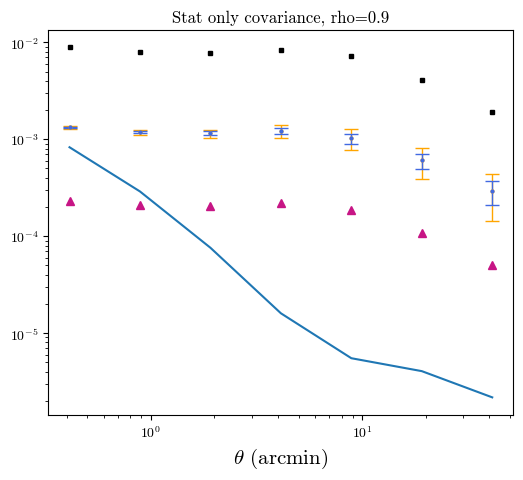

In [81]:
i = -1

nla_1h = np.load('generated_data/Y1_IA_1h+NLA_lowZ.npz')['yIA']

plt.figure(figsize=[6,5])
plt.errorbar(theta, -(1-0.5)*bar_yIA, np.sqrt(np.diag(covs[0])/(B_min1+F_theta)**2), linewidth=0, marker='o', markersize=2., color='orange',
            elinewidth=1., capsize=5.)
plt.errorbar(theta, -(1-0.5)*bar_yIA, np.sqrt(np.diag(covs[-1])/(B_min1+F_theta)**2), linewidth=0, marker='o', markersize=2., color='royalblue',
            elinewidth=1., capsize=5.)
plt.plot(theta, delM_yL, linewidth=0, marker='^', color='mediumvioletred')
plt.plot(theta, yL, lw=0, marker='s', color='black', ms=3)
plt.plot(theta, -nla_1h/(B_min1 + F_theta))
plt.xscale('log')
plt.yscale('log')
#plt.ylim([1E-5, 2E-2])
plt.title('Stat only covariance, rho=%g'%rho[i])
plt.xlabel(r'$\theta$ (arcmin)', fontsize=15)

In [72]:
np.savez('generated_data/y10_IA+errors.npz',
        bar_yIA = bar_yIA,
        covIA = cov_IA)

### Plot (1-a)yIA for different a values

In [84]:
a = [0.1,0.3,0.5,0.7]
logshift = np.zeros([len(a),len(bar_yIA)])
yIA_1mina = np.zeros([len(a),len(bar_yIA)])
for i in range(len(a)):
    yIA_1mina[i,:] = (1.-a[i]) * bar_yIA[:]
    logshift[i,:] = 0.08*theta*i

i = 0

colors = cmr.take_cmap_colors('cmr.ember', 4, cmap_range=(0.25, 0.85), return_fmt='hex')
    
plt.figure(figsize=[6,5])
plt.errorbar(theta+logshift[0], yIA_1mina[0], sigma_IA[i], linewidth=0, marker='o', markersize=5., color=colors[0],
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[1], yIA_1mina[1], sigma_IA[i], linewidth=0, marker='^', markersize=5., color=colors[1],
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[2], yIA_1mina[2], sigma_IA[i], linewidth=0, marker='s', markersize=5., color=colors[2],
            elinewidth=1., capsize=5.)
plt.errorbar(theta+logshift[3], yIA_1mina[3], sigma_IA[i], linewidth=0, marker='D', markersize=5., color=colors[3],
            elinewidth=1., capsize=5.)
plt.legend([r'$a=%g$'%a[0],r'$a=%g$'%a[1],r'$a=%g$'%a[2],r'$a=%g$'%a[3]],)

plt.hlines(y=0.,xmin=0.9*theta.min(),xmax=1.6*theta.max(), color='black')
plt.xscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.yscale('log')
#plt.ylim([-1E-4, E-3])
#plt.xlim(0.23,35)
plt.xlabel(r'$\theta$ (arcmin)', fontsize=14)
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}$', fontsize=14)
plt.title(r'Stat+Sys Covariance, $\rho=%g$'%(rho[i]), fontsize=14)
plt.savefig('y10_MEM_forecast_rho=%g.png'%rho[i], bbox_inches='tight', dpi=300)

NameError: name 'cmr' is not defined

### Get Y10 boosts

In [87]:
zlmin, zlmax = 1.0, 1.2
zsmin, zsmax = 0.05, 3.5

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10, out_file='boost_y10_zs=0.05-3.5')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=10)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=10, 
                                     out_file='y10_covs_0.05-3.5')

Pk_gg calculated


100%|█████████████████████████████████████████| 300/300 [03:03<00:00,  1.63it/s]

xi_gg calculated


Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 1 - 1.2
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 4.13853 minutes
rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.116739
Fraction of source in bin: 1
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.5
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.9
Runtime: 24.0049 mins


In [89]:
zsmin, zsmax = 0.05, 2.4

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10, out_file='boost_y10_zs=0.05-2.4')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=10)
rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=1)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=10, 
                                     out_file='y10_covs_0.05-2.4')

Pk_gg calculated


100%|█████████████████████████████████████████| 300/300 [03:58<00:00,  1.26it/s]

xi_gg calculated


Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 1 - 1.2
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 5.6124 minutes
rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.116739
Fraction of source in bin: 0.948814
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.5
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.9
Runtime: 36.9957 mins


In [88]:
zsmin, zsmax = 0.05, 1.2

B_min1, r_p = sp.get_boosts(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10, out_file='boost_y10_zs=0.05-1.2')

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=10)

rp = np.logspace(np.log10(sp.rpmin), np.log10(sp.rpmax), sp.N_bins)
theta = sp.rp_to_arcmin(rp, zleff)

lmax= 180/(theta[0]/60.)

tjp_helper.create_xi_t_sacc(zlmin=zlmin, zlmax=zlmax,
                            zsmin=zsmin, zsmax=zsmax,
                            year=10)

# sleep to let sacc file properly save to drive
time.sleep(15)

# generate y1 cov matrices for specified rho values
rho = [0.1, 0.5, 0.9]
covs = tjp_helper.get_lsst_covariance(zlmin=zlmin,zlmax=zlmax,
                                      zsmin=zsmin, zsmax=zsmax,
                                      lmax=lmax, rho=rho, year=10, 
                                     out_file='y10_covs_0.05-1.2')

Pk_gg calculated


100%|█████████████████████████████████████████| 300/300 [03:03<00:00,  1.63it/s]

xi_gg calculated


Order preserved for zl indices 0-299
xi_ls estimation complete
Finding boosts for 300 lens redshifts in range 1 - 1.2
Order preserved for zl indices 0-299
Boost estimation complete
Runtime = 4.12319 minutes
rp: [ 0.1         0.21544347  0.46415888  1.          2.15443469  4.64158883
 10.        ]
th: [ 0.13995874  0.30153197  0.64963095  1.39958745  3.01531975  6.49630947
 13.99587447]
Fraction of lenses in bin: 0.116739
Fraction of source in bin: 0.655325
Getting y1,y1 covariance...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')


/home/b7009348/WGL_project/LSST_forecast_code/tjpcov/covariance_builder.py:897: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(


Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Found covariance matrix for y1y1, getting y1,y2 for different rho...

Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.1
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.5
Computing independent covariance blocks
('lens', 'source') ('lens', 'source')
Building the covariance: placing blocks in their place
('lens', 'source') ('lens', 'source')

Getting cov[y1,y2] for rho=0.9
Runtime: 15.6552 mins
